# Test Notebook for SIDIS Framework - Flexible Model

This notebook tests the SIDIS framework, particularly the flexible model implementation (`fNPconfig_base_flexible.yaml`).

## Objectives:
1. Test parameter trainability (trainable vs fixed parameters)
2. Generate mock data in the correct format
3. Plot results and visualize parameter changes
4. Integration test with generated data

In [1]:
# Setup and imports
import sys
import pathlib
import torch
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

# Add parent directory to path so sidis can be imported as a package
parent_dir = pathlib.Path().resolve().parent.parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

from sidis.model import TrainableModel
from sidis.utilities.colors import tcolors

# Set default tensor dtype to float64 for high precision
torch.set_default_dtype(torch.float64)

print(f"{tcolors.GREEN}Setup complete!{tcolors.ENDC}")
print(f"PyTorch version: {torch.__version__}")
print(f"Default dtype: {torch.get_default_dtype()}")

Setup complete!
PyTorch version: 2.6.0
Default dtype: torch.float64


## Section 1: Model Initialization with Flexible Config

In [2]:
# Initialize the trainable model with flexible config
rootdir = pathlib.Path().resolve().parent
fnp_config = "fNPconfig_base_flexible.yaml"

print(f"{tcolors.BOLDWHITE}Initializing model with config: {fnp_config}{tcolors.ENDC}")
model = TrainableModel(fnp_config=fnp_config)

print(f"{tcolors.GREEN}Model initialized successfully!{tcolors.ENDC}")
print(f"Model is in training mode: {model.training}")

Initializing model with config: fNPconfig_base_flexible.yaml

[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_u_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_d_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_s_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_c_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_cb_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_sb_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_db_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects

## Section 2: Parameter Analysis (Trainable vs Fixed)

In [14]:
# Analyze parameters: categorize trainable vs fixed
print(f"{tcolors.BOLDWHITE}Parameter Analysis{tcolors.ENDC}")
print("=" * 80)

# Helper function to check if a buffer name represents a fixed parameter
def is_fixed_param_buffer(name: str) -> bool:
    """Check if buffer name represents a fixed parameter (not internal buffers)."""
    # Fixed parameters in flexible model: fixed_param_*
    if "fixed_param_" in name and not name.endswith("_params"):
        return True
    # Fixed parameters in flavor_dep/flavor_blind: fixed_params
    if name.endswith(".fixed_params") or name == "fixed_params":
        return True
    return False

trainable_params = {}
fixed_params = {}
total_params = 0
trainable_count = 0
fixed_count = 0

# Count trainable parameters
for name, param in model.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params[name] = param.clone().detach()
        trainable_count += param.numel()

# Count fixed parameters from buffers
for name, buffer in model.named_buffers():
    if is_fixed_param_buffer(name):
        fixed_params[name] = buffer.clone().detach()
        fixed_count += buffer.numel()
        total_params += buffer.numel()

print(f"\n{tcolors.GREEN}Summary:{tcolors.ENDC}")
print(f"  Total parameters: {total_params:,}")
if total_params > 0:
    print(f"  Trainable parameters: {trainable_count:,} ({100*trainable_count/total_params:.2f}%)")
    print(f"  Fixed parameters: {fixed_count:,} ({100*fixed_count/total_params:.2f}%)")
else:
    print(f"  Trainable parameters: {trainable_count:,}")
    print(f"  Fixed parameters: {fixed_count:,}")
print(f"\n  Trainable parameter groups: {len(trainable_params)}")
print(f"  Fixed parameter groups: {len(fixed_params)}")

# # Display fixed parameters in a table
# if len(fixed_params) > 0:
#     print(f"\n{tcolors.WARNING}Fixed Parameters (from buffers):{tcolors.ENDC}")
#     print(f"{'Parameter Name':<70} {'Shape':<15} {'Value':<25}")
#     print("-" * 110)
#     for name, buffer in sorted(fixed_params.items()):
#         short_name = name.split(".")[-1] if "." in name else name
#         # Clean up fixed parameter names for display
#         if short_name.startswith("fixed_param_"):
#             try:
#                 idx = short_name.replace("fixed_param_", "")
#                 short_name = f"fixed[{idx}]"
#             except:
#                 pass
        
#         if buffer.numel() == 1:
#             value_str = f"{buffer.data.item():.6f}"
#         elif buffer.numel() <= 5:
#             value_str = str(buffer.data.detach().cpu().numpy().tolist())
#         else:
#             value_str = f"min={buffer.data.min().item():.6f}, max={buffer.data.max().item():.6f}"
        
#         print(f"{short_name:<70} {str(list(buffer.shape)):<15} {value_str[:25]}")

# Store initial values for comparison later
initial_trainable = {name: param.clone() for name, param in trainable_params.items()}
initial_fixed = {name: buffer.clone() for name, buffer in fixed_params.items()}

print(f"\n{tcolors.GREEN}Initial parameter values stored for comparison{tcolors.ENDC}")

Parameter Analysis

Summary:
  Total parameters: 157
  Trainable parameters: 65 (41.40%)
  Fixed parameters: 92 (58.60%)

  Trainable parameter groups: 65
  Fixed parameter groups: 92

Initial parameter values stored for comparison


## Section 3: Mock Data Generation

Generate synthetic event data in the correct format: `[x, PhT, Q, z]`

In [4]:
def generate_mock_events(n_events=100, seed=42, polarized=False):
    """
    Generate synthetic SIDIS event data.
    
    Parameters:
    -----------
    n_events : int
        Number of events to generate
    seed : int
        Random seed for reproducibility
    polarized : bool
        If True, include phih and phis angles (6 columns)
        If False, only include x, PhT, Q, z (4 columns)
    
    Returns:
    --------
    torch.Tensor
        Event tensor of shape (n_events, 4) or (n_events, 6)
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Realistic kinematic ranges
    x_min, x_max = 0.01, 0.9      # Bjorken x
    PhT_min, PhT_max = 0.1, 5.0   # Transverse momentum (GeV)
    Q_min, Q_max = 2.0, 100.0      # Hard scale (GeV)
    z_min, z_max = 0.1, 0.9        # Fragmentation fraction
    
    # Generate random values
    x = np.random.uniform(x_min, x_max, n_events)
    PhT = np.random.uniform(PhT_min, PhT_max, n_events)
    Q = np.random.uniform(Q_min, Q_max, n_events)
    z = np.random.uniform(z_min, z_max, n_events)
    
    # Create tensor
    events = torch.tensor(np.column_stack([x, PhT, Q, z]), dtype=torch.float64)
    
    # Add polarization angles if requested
    if polarized:
        phih = np.random.uniform(0, 2*np.pi, n_events)
        phis = np.random.uniform(0, 2*np.pi, n_events)
        events = torch.cat([events, torch.tensor(np.column_stack([phih, phis]), dtype=torch.float64)], dim=1)
    
    return events

# Generate test datasets
print(f"{tcolors.BOLDWHITE}Generating mock event data...{tcolors.ENDC}")

# Generate datasets of different sizes
mock_data_10 = generate_mock_events(n_events=10, seed=42)
mock_data_100 = generate_mock_events(n_events=100, seed=42)
mock_data_1000 = generate_mock_events(n_events=1000, seed=42)
mock_data_polarized = generate_mock_events(n_events=50, seed=42, polarized=True)

print(f"Generated datasets:")
print(f"  - 10 events: shape {mock_data_10.shape}")
print(f"  - 100 events: shape {mock_data_100.shape}")
print(f"  - 1000 events: shape {mock_data_1000.shape}")
print(f"  - 50 polarized events: shape {mock_data_polarized.shape}")

# Save one dataset for use with main.py
output_file = pathlib.Path().resolve().joinpath("mock_events.dat")
torch.save(mock_data_100, output_file)
print(f"\n{tcolors.GREEN}Saved mock data to: {output_file}{tcolors.ENDC}")

# Display sample events
print(f"\n{tcolors.BOLDWHITE}Sample events (first 5):{tcolors.ENDC}")
print(mock_data_100[:5])

Generating mock event data...
Generated datasets:
  - 10 events: shape torch.Size([10, 4])
  - 100 events: shape torch.Size([100, 4])
  - 1000 events: shape torch.Size([1000, 4])
  - 50 polarized events: shape torch.Size([50, 6])

Saved mock data to: /Users/cbissolotti/anl/projects/tmd/sidis/tests/mock_events.dat

Sample events (first 5):
tensor([[ 0.3433,  0.2540, 64.9191,  0.1413],
        [ 0.8561,  3.2184, 10.2457,  0.5251],
        [ 0.6615,  1.6403, 17.8396,  0.5325],
        [ 0.5428,  2.5920, 90.0583,  0.6099],
        [ 0.1489,  4.5471, 61.4300,  0.6809]])


## Section 4: Parameter Change Test with Optimizer

Test that trainable parameters change while fixed parameters remain unchanged.

In [5]:
# Load toy events for testing
events_file = rootdir.joinpath("tests/mock_events.dat")
events_tensor = torch.load(events_file)
print(f"{tcolors.BOLDWHITE}Loaded events from {events_file}{tcolors.ENDC}")
print(f"Event data shape: {events_tensor.shape}")
print(f"Number of events: {events_tensor.shape[0]}")

# Run initial forward pass
with torch.no_grad():
    initial_output = model(events_tensor)
print(f"Initial output shape: {initial_output.shape}")
print(f"Initial output range: [{initial_output.min().item():.6e}, {initial_output.max().item():.6e}]")

Loaded events from /Users/cbissolotti/anl/projects/tmd/sidis/tests/mock_events.dat
Event data shape: torch.Size([100, 4])
Number of events: 100
Initial output shape: torch.Size([100])
Initial output range: [-3.926126e-05, 2.857620e-04]


In [6]:
# Set up optimizer and perform a few optimization steps
print(f"{tcolors.BOLDWHITE}Setting up optimizer and performing optimization steps...{tcolors.ENDC}")

# Create optimizer (only trainable parameters will be updated)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Create a dummy target (slightly perturbed from initial output)
target = initial_output * 2  # 200% increase as target

# Check 
print("initial", initial_output)
print("target:", target)

# Perform optimization steps
n_steps = 10
losses = []

for step in range(n_steps):
    optimizer.zero_grad()
    
    # Forward pass
    output = model(events_tensor)
    
    # Compute loss (MSE between output and target)
    loss = torch.nn.functional.mse_loss(output, target)
    losses.append(loss.item())
    
    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    if (step + 1) % 2 == 0:
        print(f"  Step {step+1}/{n_steps}: Loss = {loss.item():.6e}")

print(f"\n{tcolors.GREEN}Optimization completed!{tcolors.ENDC}")
print(f"Final loss: {losses[-1]:.6e}")
print(f"Loss reduction: {(losses[0] - losses[-1])/losses[0]*100:.2f}%")

Setting up optimizer and performing optimization steps...
initial tensor([ 2.2299e-09, -1.8576e-10, -5.5677e-10,  3.1384e-12,  2.9093e-10,
         5.6274e-06,  3.0383e-07, -5.1480e-13, -1.7713e-06,  1.5372e-08,
         5.2265e-06,  3.7602e-13, -5.5981e-13, -9.1677e-10,  1.8344e-10,
        -1.7639e-09, -9.5332e-10,  2.5652e-10, -6.7688e-11,  2.7500e-10,
         1.2757e-12,  4.6389e-10, -3.8286e-08,  1.4455e-08,  9.5380e-10,
        -2.2605e-11,  3.3398e-10, -3.0021e-11,  2.2037e-11,  5.0329e-07,
         1.4259e-11,  2.0831e-09,  1.7238e-07, -1.4546e-12, -4.1525e-12,
        -6.5276e-13,  5.7251e-10, -1.8255e-05,  1.0762e-11, -1.0479e-08,
         2.7305e-09,  2.6159e-11,  4.1676e-06, -1.8754e-13, -3.9261e-05,
         5.5345e-12,  3.6200e-10, -1.6887e-13,  5.1591e-11,  8.6925e-10,
        -1.4621e-12,  1.4237e-11,  1.8961e-13, -2.3911e-11, -1.7151e-09,
         5.4600e-13,  3.2273e-09,  2.7987e-10,  3.7358e-08, -7.0990e-08,
         3.2224e-10,  8.5804e-11, -3.5745e-10,  2.3467e-10

In [7]:
# Verify parameter changes
print(f"{tcolors.BOLDWHITE}Verifying parameter changes...{tcolors.ENDC}")
print("=" * 80)

# Check trainable parameters
trainable_changed = 0
trainable_unchanged = 0
max_trainable_change = 0.0

for name, param in model.named_parameters():
    if param.requires_grad:
        initial = initial_trainable[name]
        current = param.detach()
        
        # Compute change
        if initial.shape == current.shape:
            change = torch.abs(current - initial).max().item()
            if change > 1e-10:  # Threshold for "changed"
                trainable_changed += 1
                max_trainable_change = max(max_trainable_change, change)
            else:
                trainable_unchanged += 1

print(f"\n{tcolors.GREEN}Trainable Parameters:{tcolors.ENDC}")
print(f"  Changed: {trainable_changed}")
print(f"  Unchanged: {trainable_unchanged}")
print(f"  Max change: {max_trainable_change:.6e}")

# Check fixed parameters (stored as buffers)
fixed_changed = 0
fixed_unchanged = 0
max_fixed_change = 0.0

# Helper function to check if a buffer name represents a fixed parameter
def is_fixed_param_buffer(name: str) -> bool:
    if "fixed_param_" in name and not name.endswith("_params"):
        return True
    if name.endswith(".fixed_params") or name == "fixed_params":
        return True
    return False

for name, buffer in model.named_buffers():
    if is_fixed_param_buffer(name) and name in initial_fixed:
        initial = initial_fixed[name]
        current = buffer.detach()
        
        # Compute change
        if initial.shape == current.shape:
            change = torch.abs(current - initial).max().item()
            if change > 1e-10:  # Threshold for "changed"
                fixed_changed += 1
                max_fixed_change = max(max_fixed_change, change)
            else:
                fixed_unchanged += 1

print(f"\n{tcolors.WARNING}Fixed Parameters:{tcolors.ENDC}")
print(f"  Changed: {fixed_changed}")
print(f"  Unchanged: {fixed_unchanged}")
print(f"  Max change: {max_fixed_change:.6e}")

# Summary
print(f"\n{tcolors.BOLDWHITE}Summary:{tcolors.ENDC}")
if trainable_changed > 0 and fixed_changed == 0:
    print(f"{tcolors.GREEN}✓ SUCCESS: Trainable parameters changed, fixed parameters unchanged!{tcolors.ENDC}")
else:
    print(f"{tcolors.WARNING}⚠ WARNING: Unexpected behavior detected{tcolors.ENDC}")
    if trainable_changed == 0:
        print(f"  - No trainable parameters changed")
    if fixed_changed > 0:
        print(f"  - {fixed_changed} fixed parameters changed (should be 0)")

Verifying parameter changes...

Trainable Parameters:
  Changed: 1
  Unchanged: 64
  Max change: 5.394816e-04

Fixed Parameters:
  Changed: 0
  Unchanged: 92
  Max change: 0.000000e+00

Summary:
✓ SUCCESS: Trainable parameters changed, fixed parameters unchanged!


## Section 5: Model Evaluation and Plotting

In [8]:
# Evaluate model on mock data
print(f"{tcolors.BOLDWHITE}Evaluating model on mock data...{tcolors.ENDC}")

# Use the 100-event dataset
with torch.no_grad():
    cross_sections = model(mock_data_100)

print(f"Cross-section shape: {cross_sections.shape}")
print(f"Cross-section range: [{cross_sections.min().item():.6e}, {cross_sections.max().item():.6e}]")
print(f"Mean cross-section: {cross_sections.mean().item():.6e}")

# Extract kinematic variables for plotting
x_vals = mock_data_100[:, 0].numpy()
PhT_vals = mock_data_100[:, 1].numpy()
Q_vals = mock_data_100[:, 2].numpy()
z_vals = mock_data_100[:, 3].numpy()
xsec_vals = cross_sections.numpy()

Evaluating model on mock data...
Cross-section shape: torch.Size([100])
Cross-section range: [-3.926230e-05, 2.857672e-04]
Mean cross-section: 2.620129e-06


Creating plots...


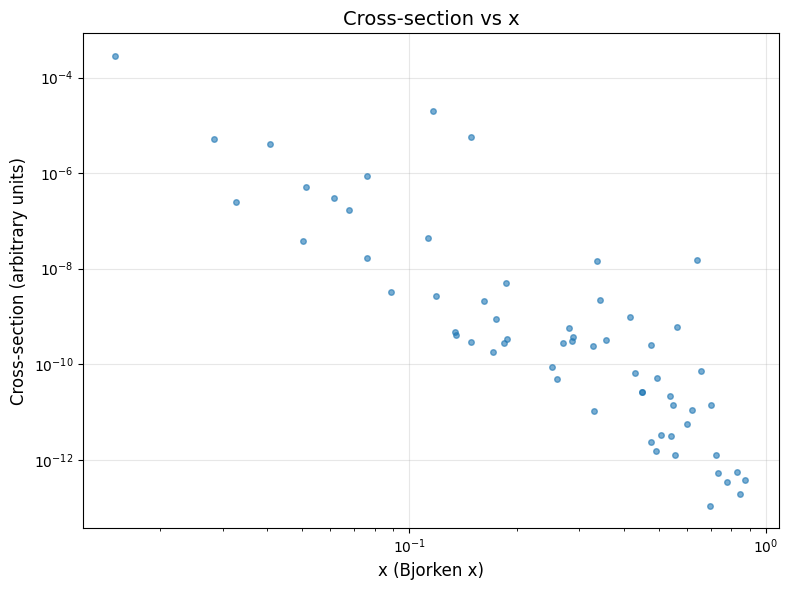

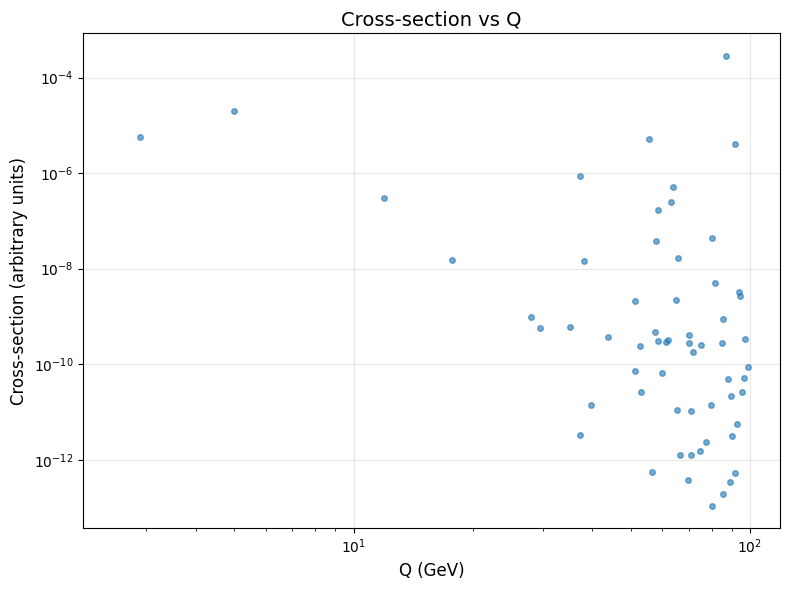

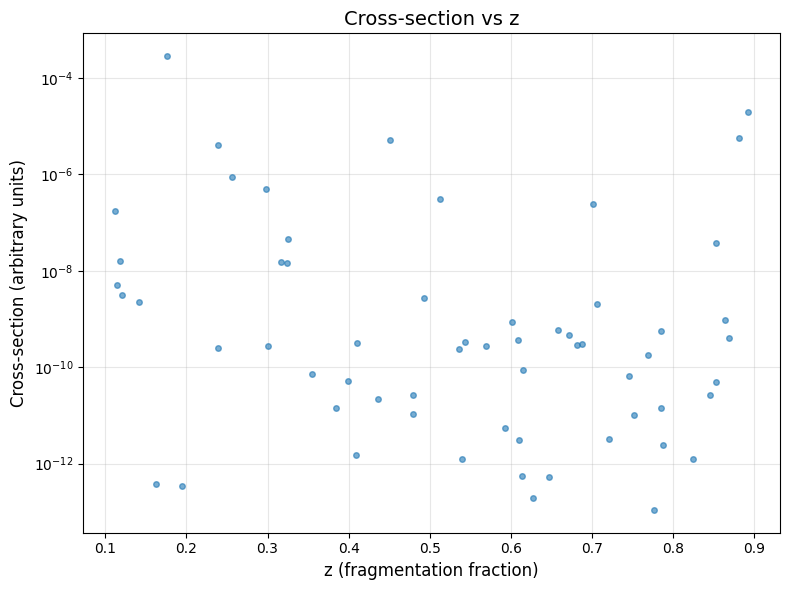

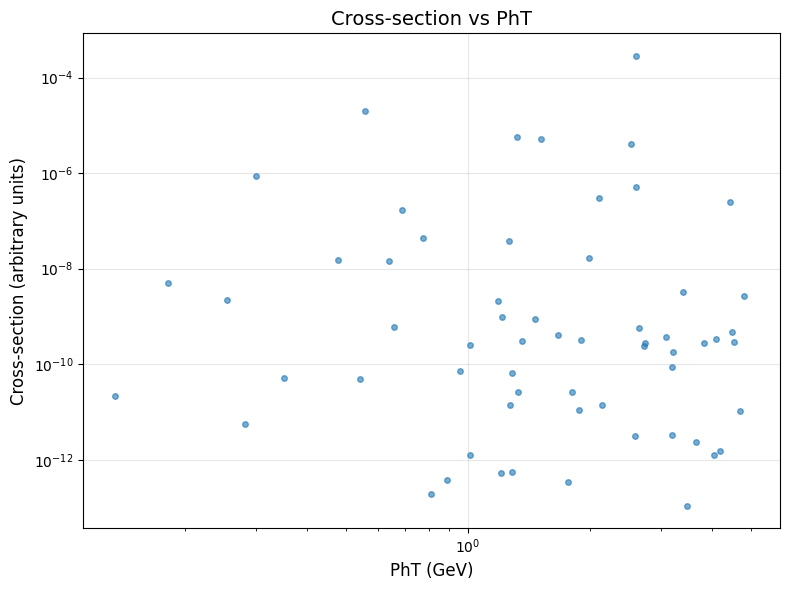

In [9]:
# Plotting functions
def plot_cross_section_vs_kinematic(kinematic_vals, xsec_vals, xlabel, title, log_scale=True):
    """Plot cross-section vs a kinematic variable."""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    if log_scale:
        ax.loglog(kinematic_vals, xsec_vals, 'o', alpha=0.6, markersize=4)
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        ax.semilogy(kinematic_vals, xsec_vals, 'o', alpha=0.6, markersize=4)
        ax.set_yscale('log')
    
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('Cross-section (arbitrary units)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig, ax

# Create plots
print(f"{tcolors.BOLDWHITE}Creating plots...{tcolors.ENDC}")

# Plot 1: Cross-section vs x
fig1, ax1 = plot_cross_section_vs_kinematic(
    x_vals, xsec_vals, 
    xlabel='x (Bjorken x)', 
    title='Cross-section vs x'
)
plt.show()

# Plot 2: Cross-section vs Q
fig2, ax2 = plot_cross_section_vs_kinematic(
    Q_vals, xsec_vals,
    xlabel='Q (GeV)',
    title='Cross-section vs Q'
)
plt.show()

# Plot 3: Cross-section vs z
fig3, ax3 = plot_cross_section_vs_kinematic(
    z_vals, xsec_vals,
    xlabel='z (fragmentation fraction)',
    title='Cross-section vs z',
    log_scale=False
)
plt.show()

# Plot 4: Cross-section vs PhT
fig4, ax4 = plot_cross_section_vs_kinematic(
    PhT_vals, xsec_vals,
    xlabel='PhT (GeV)',
    title='Cross-section vs PhT'
)
plt.show()

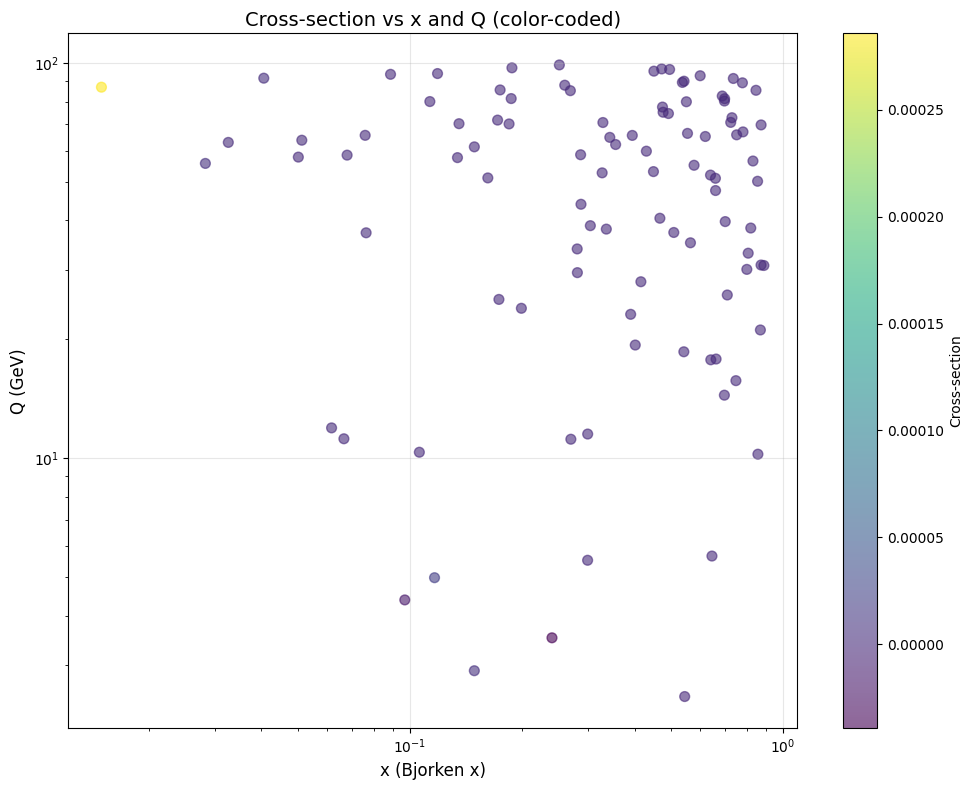

/var/folders/01/gzryl8m96dz9nj20ctqdsyw40000gq/T/ipykernel_16925/789148907.py:19: RuntimeWarning: invalid value encountered in log10
  ax.hist(np.log10(xsec_vals), bins=30, edgecolor='black', alpha=0.7)


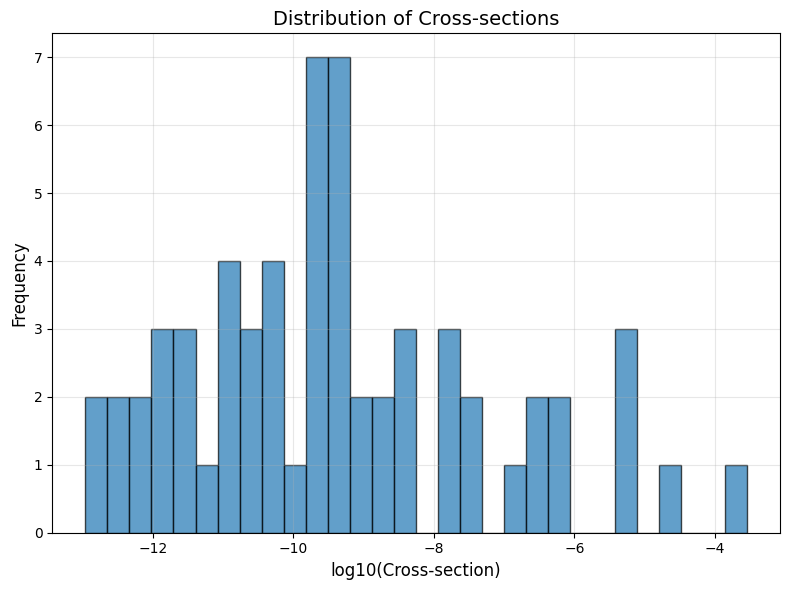

In [10]:
# 2D plot: Cross-section vs x and Q
fig, ax = plt.subplots(figsize=(10, 8))

# Create scatter plot colored by cross-section
scatter = ax.scatter(x_vals, Q_vals, c=xsec_vals, s=50, alpha=0.6, 
                     cmap='viridis')
ax.set_xlabel('x (Bjorken x)', fontsize=12)
ax.set_ylabel('Q (GeV)', fontsize=12)
ax.set_title('Cross-section vs x and Q (color-coded)', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
plt.colorbar(scatter, ax=ax, label='Cross-section')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Histogram of cross-sections
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(np.log10(xsec_vals), bins=30, edgecolor='black', alpha=0.7)
ax.set_xlabel('log10(Cross-section)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Cross-sections', fontsize=14)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Section 6: Parameter Change Visualization

Visualizing parameter changes...


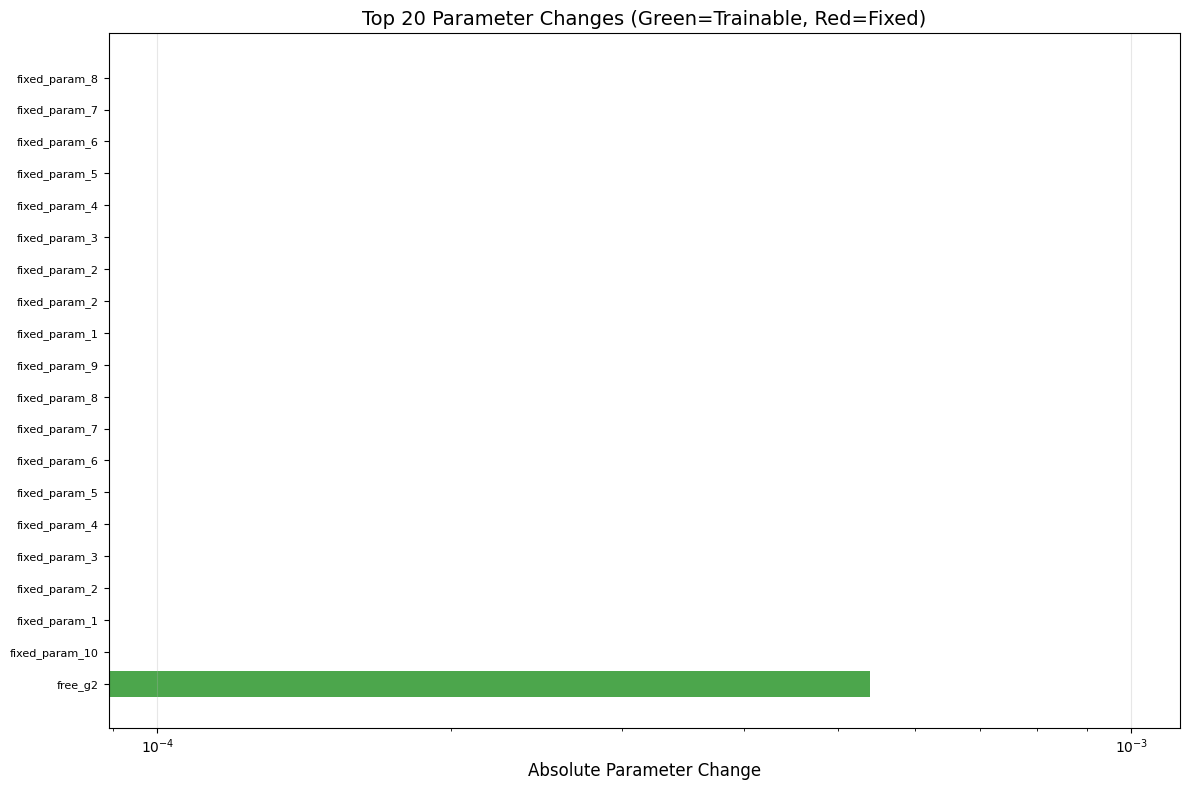

Plotted changes for 20 parameters


In [11]:
# Visualize parameter changes
print(f"{tcolors.BOLDWHITE}Visualizing parameter changes...{tcolors.ENDC}")

# Collect parameter changes
param_names = []
param_changes = []
param_types = []

# Helper function to check if a buffer name represents a fixed parameter
def is_fixed_param_buffer(name: str) -> bool:
    if "fixed_param_" in name and not name.endswith("_params"):
        return True
    if name.endswith(".fixed_params") or name == "fixed_params":
        return True
    return False

for name, param in model.named_parameters():
    if param.requires_grad:
        initial = initial_trainable[name]
        current = param.detach()
        
        if initial.shape == current.shape and initial.numel() == 1:
            change = torch.abs(current - initial).item()
            if change > 1e-10:
                param_names.append(name.split('.')[-1])  # Short name
                param_changes.append(change)
                param_types.append('trainable')

# Check fixed parameters from buffers
for name, buffer in model.named_buffers():
    if is_fixed_param_buffer(name) and name in initial_fixed:
        initial = initial_fixed[name]
        current = buffer.detach()
        
        if initial.shape == current.shape and initial.numel() == 1:
            change = torch.abs(current - initial).item()
            param_names.append(name.split('.')[-1])
            param_changes.append(change)
            param_types.append('fixed')

# Plot parameter changes
if len(param_changes) > 0:
    # Take top 20 parameters by change magnitude
    sorted_indices = np.argsort(param_changes)[::-1][:20]
    top_names = [param_names[i] for i in sorted_indices]
    top_changes = [param_changes[i] for i in sorted_indices]
    top_types = [param_types[i] for i in sorted_indices]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ['green' if t == 'trainable' else 'red' for t in top_types]
    ax.barh(range(len(top_names)), top_changes, color=colors, alpha=0.7)
    ax.set_yticks(range(len(top_names)))
    ax.set_yticklabels(top_names, fontsize=8)
    ax.set_xlabel('Absolute Parameter Change', fontsize=12)
    ax.set_title('Top 20 Parameter Changes (Green=Trainable, Red=Fixed)', fontsize=14)
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    print(f"Plotted changes for {len(top_names)} parameters")
else:
    print("No single-element parameters found for visualization")

## Section 7: Integration Test

Complete end-to-end test: load mock data, run model, compare before/after optimization

In [12]:
# Integration test: Load a fresh model and test with mock data
print(f"{tcolors.BOLDWHITE}Integration Test: Full workflow{tcolors.ENDC}")
print("=" * 80)

# Create a fresh model instance
print("\n1. Creating fresh model instance...")
model_fresh = TrainableModel(fnp_config=fnp_config)
print(f"   ✓ Model created")

# Load mock data
print("\n2. Loading mock data...")
test_data = mock_data_100
print(f"   ✓ Loaded {test_data.shape[0]} events")

# Run forward pass before optimization
print("\n3. Running forward pass (before optimization)...")
with torch.no_grad():
    output_before = model_fresh(test_data)
print(f"   ✓ Output shape: {output_before.shape}")
print(f"   ✓ Output range: [{output_before.min().item():.6e}, {output_before.max().item():.6e}]")

# Store initial parameters
print("\n4. Storing initial parameters...")
initial_params_fresh = {}
for name, param in model_fresh.named_parameters():
    if param.requires_grad:
        initial_params_fresh[name] = param.clone().detach()
print(f"   ✓ Stored {len(initial_params_fresh)} trainable parameter groups")

# Perform optimization
print("\n5. Performing optimization...")
optimizer_fresh = torch.optim.Adam(model_fresh.parameters(), lr=0.01)
target_fresh = output_before * 1.05  # 5% target

for step in range(5):
    optimizer_fresh.zero_grad()
    output = model_fresh(test_data)
    loss = torch.nn.functional.mse_loss(output, target_fresh)
    loss.backward()
    optimizer_fresh.step()
    if step == 0:
        initial_loss = loss.item()
    if step == 4:
        final_loss = loss.item()

print(f"   ✓ Optimization completed")
print(f"   ✓ Loss: {initial_loss:.6e} → {final_loss:.6e}")

# Run forward pass after optimization
print("\n6. Running forward pass (after optimization)...")
with torch.no_grad():
    output_after = model_fresh(test_data)
print(f"   ✓ Output shape: {output_after.shape}")
print(f"   ✓ Output range: [{output_after.min().item():.6e}, {output_after.max().item():.6e}]")

# Verify parameters changed
print("\n7. Verifying parameter changes...")
params_changed = 0
for name, param in model_fresh.named_parameters():
    if param.requires_grad and name in initial_params_fresh:
        initial = initial_params_fresh[name]
        current = param.detach()
        if initial.shape == current.shape:
            change = torch.abs(current - initial).max().item()
            if change > 1e-10:
                params_changed += 1

print(f"   ✓ {params_changed} trainable parameter groups changed")

# Compare outputs
print("\n8. Comparing outputs...")
output_diff = torch.abs(output_after - output_before).mean().item()
print(f"   ✓ Mean absolute difference: {output_diff:.6e}")
print(f"   ✓ Relative change: {output_diff / output_before.mean().item() * 100:.2f}%")

print(f"\n{tcolors.GREEN}{'='*80}{tcolors.ENDC}")
print(f"{tcolors.GREEN}Integration test completed successfully!{tcolors.ENDC}")
print(f"{tcolors.GREEN}{'='*80}{tcolors.ENDC}")

Integration Test: Full workflow

1. Creating fresh model instance...

[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_u_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_d_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_s_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_c_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_cb_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_sb_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_db_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/

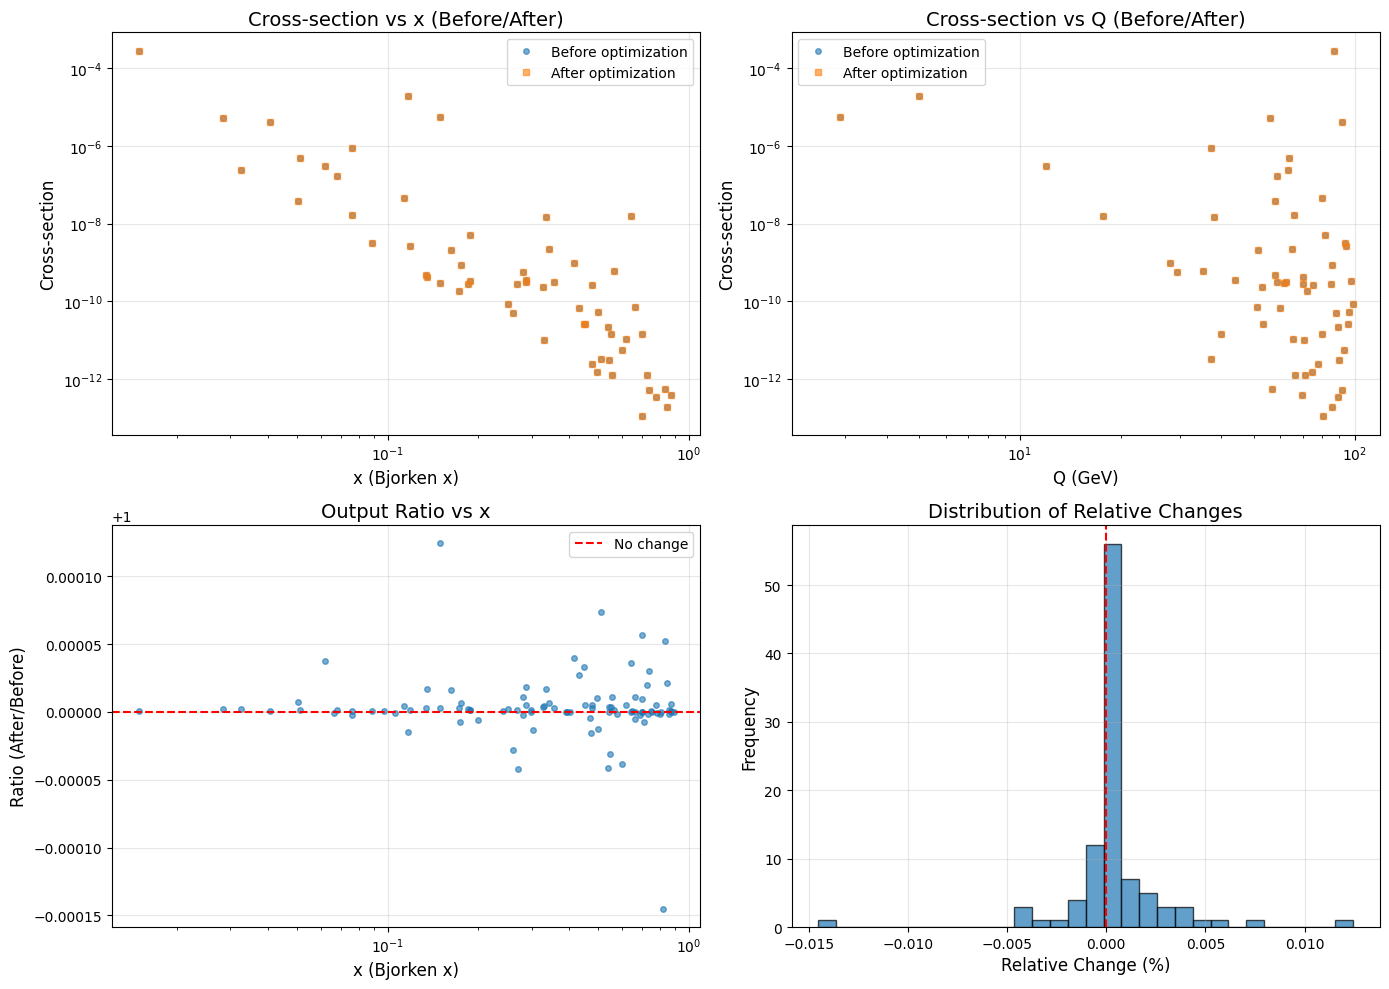

Comparison plots created!


In [13]:
# Plot comparison: before vs after optimization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cross-section vs x (before and after)
ax = axes[0, 0]
ax.loglog(x_vals, output_before.numpy(), 'o', alpha=0.6, label='Before optimization', markersize=4)
ax.loglog(x_vals, output_after.numpy(), 's', alpha=0.6, label='After optimization', markersize=4)
ax.set_xlabel('x (Bjorken x)', fontsize=12)
ax.set_ylabel('Cross-section', fontsize=12)
ax.set_title('Cross-section vs x (Before/After)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Cross-section vs Q (before and after)
ax = axes[0, 1]
ax.loglog(Q_vals, output_before.numpy(), 'o', alpha=0.6, label='Before optimization', markersize=4)
ax.loglog(Q_vals, output_after.numpy(), 's', alpha=0.6, label='After optimization', markersize=4)
ax.set_xlabel('Q (GeV)', fontsize=12)
ax.set_ylabel('Cross-section', fontsize=12)
ax.set_title('Cross-section vs Q (Before/After)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Ratio (after/before)
ax = axes[1, 0]
ratio = (output_after / output_before).numpy()
ax.semilogx(x_vals, ratio, 'o', alpha=0.6, markersize=4)
ax.axhline(y=1.0, color='r', linestyle='--', label='No change')
ax.set_xlabel('x (Bjorken x)', fontsize=12)
ax.set_ylabel('Ratio (After/Before)', fontsize=12)
ax.set_title('Output Ratio vs x', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Distribution of changes
ax = axes[1, 1]
relative_change = ((output_after - output_before) / output_before * 100).numpy()
ax.hist(relative_change, bins=30, edgecolor='black', alpha=0.7)
ax.set_xlabel('Relative Change (%)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Relative Changes', fontsize=14)
ax.axvline(x=0, color='r', linestyle='--')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"{tcolors.GREEN}Comparison plots created!{tcolors.ENDC}")

## Summary

This notebook has successfully:
1. ✓ Loaded and initialized the flexible model
2. ✓ Analyzed trainable vs fixed parameters
3. ✓ Verified that trainable parameters change while fixed parameters remain unchanged
4. ✓ Generated mock data in the correct format
5. ✓ Created comprehensive plots of cross-sections vs kinematic variables
6. ✓ Performed integration testing with the full workflow

The framework is working correctly!